In [54]:
install.packages("e1071")

Warning message in install.packages("e1071"):
“installation of package ‘e1071’ had non-zero exit status”Updating HTML index of packages in '.Library'
Making 'packages.html' ... done


In [30]:
library(devtools)

In [55]:
library(tidyr)
library(readr)
library(plyr)
library(dplyr)
library(stringr)
library(rgdal)
library(ggplot2)
library(sp)

In [56]:
daily<-read_csv("https://raw.githubusercontent.com/ericnost/gfw/setup/data/2016-12-22.csv")

Parsed with column specification:
cols(
  date = col_date(format = ""),
  lat_bin = col_double(),
  lon_bin = col_double(),
  mmsi = col_double(),
  fishing_hours = col_double(),
  lat = col_double(),
  long = col_double(),
  latlong = col_character()
)


OGR data source with driver: GeoJSON 
Source: "https://raw.githubusercontent.com/ericnost/gfw/setup/data/countries.geojson", layer: "countries"
with 255 features
It has 94 fields
OGR data source with driver: GeoJSON 
Source: "https://raw.githubusercontent.com/ericnost/gfw/setup/data/wcpfc.geojson", layer: "wcpfc"
with 2 features
It has 1 fields
OGR data source with driver: GeoJSON 
Source: "https://raw.githubusercontent.com/ericnost/gfw/setup/data/spc.geojson", layer: "spc"
with 2 features
It has 1 fields


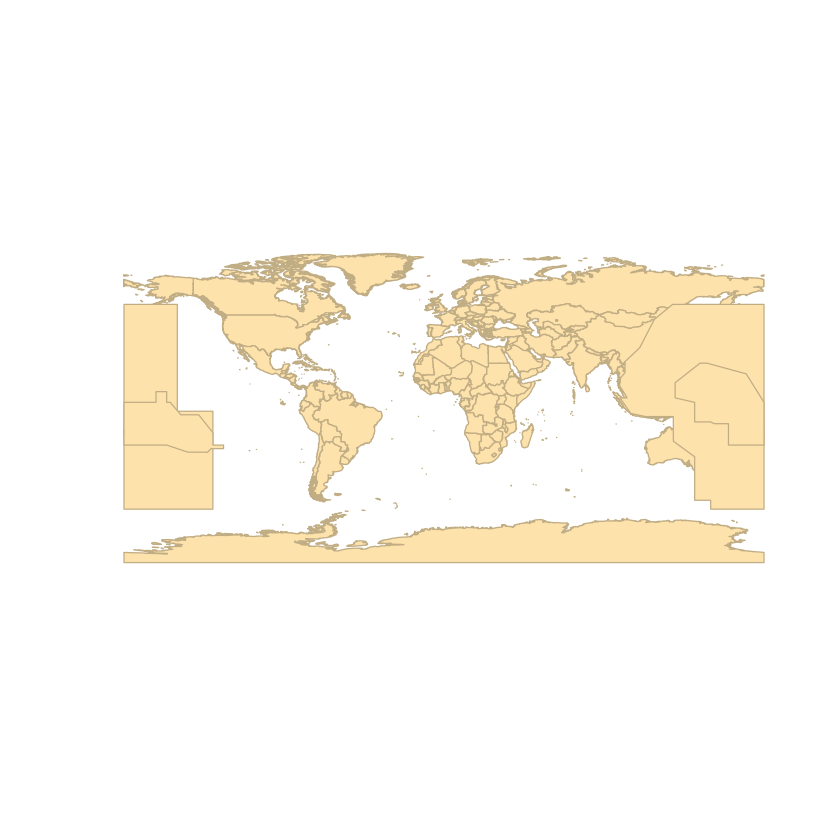

In [57]:
#load geographies
countries <- readOGR(dsn="https://raw.githubusercontent.com/ericnost/gfw/setup/data/countries.geojson")
plot(countries, border="wheat3", col="wheat1")

wcpfc_map <- readOGR(dsn="https://raw.githubusercontent.com/ericnost/gfw/setup/data/wcpfc.geojson") #<- readOGR(dsn = "https://github.com/ericnost/gfw/tree/setup/shapefiles/Pacific", layer = "WCPFC") 
plot(wcpfc_map, border="wheat3", col="wheat2", add=T)

spc <- readOGR(dsn="https://raw.githubusercontent.com/ericnost/gfw/setup/data/spc.geojson")
plot(spc, border="wheat3", col="wheat1", add=T)


Regions defined for each Polygons
ERROR while rich displaying an object: Error in FUN(X[[i]], ...): object 'data.coords' not found

Traceback:
1. FUN(X[[i]], ...)
2. tryCatch(withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler), error = outer_handler)
3. tryCatchList(expr, classes, parentenv, handlers)
4. tryCatchOne(expr, names, parentenv, handlers[[1L]])
5. doTryCatch(return(expr), name, parentenv, handler)
6. withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler)
7. repr::mime2repr[[mime]](ob

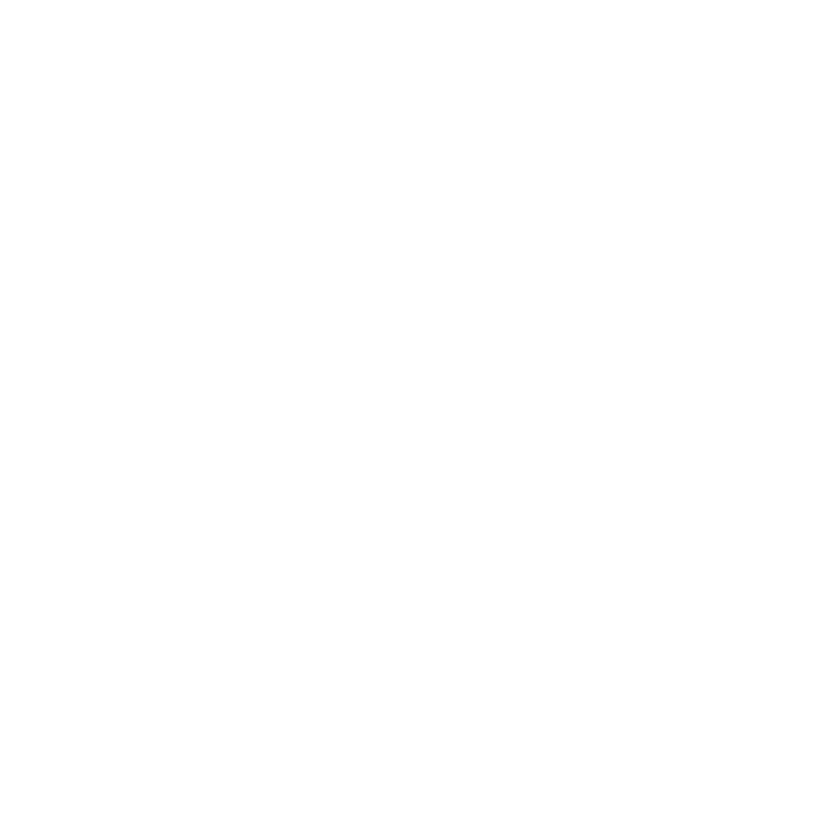

In [41]:
#head(countries)
ggplot(data = countries, aes(x = data.coords[,1], y = data.coords[,2], fill = data.SOVEREIGNT)) +
    geom_polygon(colour = "black") +
    coord_equal() +
    theme()

In [ ]:

#load main vessel DB
setwd("~/OneDrive - University of Guelph/research/GFW/vessels")
vessels_full <- read_csv("vessels.csv")

#load WCPFC DB
setwd("~/OneDrive - University of Guelph/research/GFW/")
wcpfc <- read_csv("RFV_database_export.csv")


In [ ]:

ky<-wcpfc[grep("KYOKUYO", wcpfc$`Owner Name`),] #5 vessels
dongwon<-wcpfc[grep("DONGW", wcpfc$`Owner Name`),] #44 vessels

#merge dongwon and ky
dongwon<-rbind(dongwon,ky)

dongwon_imos<-dongwon$`IMO-LR`
dongwon_ircs<-dongwon$IRCS

#filtered<-vessels_full[which(vessels_full$imo %in% dongwon_imos),]
filtered<-vessels_full[which(vessels_full$imo %in% dongwon_imos | vessels_full$callsign %in% dongwon_ircs ),]

dailies_filtered<-daily[which(daily$mmsi %in% filtered$mmsi),] #filtered to dongwon
dailies_extracted<-daily[-which(daily$mmsi %in% filtered$mmsi),] #all other vessels

#join vessels and effort
dongwon_fishing<-merge(dailies_filtered, filtered, by = "mmsi")
allother_fishing<-merge(dailies_extracted, vessels_full, by ="mmsi")

#aggregate by lat/long and vessel - all others
aggregated<-allother_fishing %>%
  group_by(lat_bin, lon_bin) %>% #, flag #aggregated at specific lat long bins
  summarise(totalFishingHours=sum(fishing_hours), flags=n_distinct(flag), count=n_distinct(mmsi)) #total fishing effort at this lat long, number of unique mmsis at this lat long
aggregated$lat_bin<-(aggregated$lat_bin/10)+.05
aggregated$lon_bin<-(aggregated$lon_bin/10)+.05


#aggregate by lat/long and vessel - - Dongwon
dongwon_aggregated<-dongwon_fishing %>%
  group_by(lat_bin, lon_bin) %>% #, flag #aggregated at specific lat long bins
  summarise(totalFishingHours=sum(fishing_hours), flag="DONG", count=n_distinct(mmsi)) #total fishing effort at this lat long, number of unique mmsis at this lat long
dongwon_aggregated$lat_bin<-(dongwon_aggregated$lat_bin/10)+.05
dongwon_aggregated$lon_bin<-(dongwon_aggregated$lon_bin/10)+.05

#max - producing a set of points with the max ALL OTHER FISHING for each lat/lon bin and reporting the flag
aggregated_max<-allother_fishing %>%
  group_by(lat_bin, lon_bin, flag) %>% #, flag #aggregated at specific lat long bins
  summarise(totalFishingHours=sum(fishing_hours)) #total fishing effort at this lat long, number of unique mmsis at this lat long

aggregated_max<-aggregated_max %>% 
  group_by(lat_bin, lon_bin) %>%
  filter(totalFishingHours == max(totalFishingHours))  #max here 553 -365
aggregated$lat_bin<-(aggregated$lat_bin/10)+.05
aggregated$lon_bin<-(aggregated$lon_bin/10)+.05


#dongwon and all other together maxed....
#first, rbind
drops <- c("count","z")
dongwon_aggregated<-dongwon_aggregated[,-c(5)]
colnames(dongwon_aggregated)<-c("lat_bin", "lon_bin", "totalFishingHours", "flag")
total<-rbind(aggregated_max, dongwon_aggregated)
#then, find max for each lat_bin, lon_bin
total<-total %>% 
  group_by(lat_bin, lon_bin) %>%
  filter(totalFishingHours == max(totalFishingHours))  #max here 553 -365

write_csv(aggregated, "allotherfishingTOTAL.csv")
write_csv(aggregated_max, "allotherfishingMAX2014.csv")
write_csv(aggflag, "allotherfishing-specificflags-TOTAL.csv")
write_csv(dongwon_aggregated, "dongwonTOTAL2014.csv")
write_csv(totaltest, "TOTALMAX2014.csv")


#analysis
#bbox
#-9.84 > < 4.7 lat
#-176.85 >< -151.41 long

#WC bbox #SPC bbox
#create points out of dongwon_agg and aggregated?
coordinates(dongwon_aggregated)<-c("lon_bin", "lat_bin")
coordinates(aggregated)<-c("lon_bin", "lat_bin")
#crs transformation
proj4string(dongwon_aggregated)<- CRS("+init=epsg:4326")
proj4string(aggregated)<- CRS("+init=epsg:4326")
proj4string(wcpfc_map)<- CRS("+init=epsg:4326")
proj4string(spc)<- CRS("+init=epsg:4326")

#clip
dongwon_clipped<-dongwon_aggregated[spc, ] #spc
clipped<-aggregated[spc, ] #spc


#project
p = CRS("+proj=aea +lat_0=-30 +lat_1=30 +lon_0=-180")
wcpfc_map<-spTransform(wcpfc_map, p)
spc<-spTransform(spc, p)
countries<-spTransform(countries, p)
clipped<-spTransform(clipped, p)
dongwon_clipped<-spTransform(dongwon_clipped, p)

#plot
#DEVELOP COLOR SCALE, CHANGE FROM + to POINTS
library(RColorBrewer) # creates nice color schemes
library(classInt) 
nclr <- 4
plotclr <- brewer.pal(nclr,"BuPu")
class <- classIntervals(dongwon_clipped$totalFishingHours, nclr, style="quantile") #clipped
colcode <- findColours(class, plotclr)
#plot
plot(countries, border="wheat3", col="wheat1")
#plot(wcpfc_map, border="wheat3", col=rgb(red = 1, green = 0, blue = 0, alpha = 0.5), add = TRUE)
plot(spc, border="wheat3", add = TRUE) #col=rgb(red = 0, green = 0, blue = 1, alpha = 0.5), 
plot(dongwon_clipped, cex=.1, border="wheat2", col=colcode, pch=19, add = TRUE)
plot(clipped, border="wheat1", col="wheat1", pch=19, add = TRUE)



#filter aggregated stats to bbox
dongwon_aggregated_bbox<-dongwon_aggregated[which(dongwon_aggregated$lat_bin > -9.84 & dongwon_aggregated$lat_bin < 4.7 & dongwon_aggregated$lon_bin > -176.85 & dongwon_aggregated$lon_bin < -151.41),]
aggregated_bbox<-aggregated[which(aggregated$lat_bin > -9.84 & aggregated$lat_bin < 4.7 & aggregated$lon_bin > -176.85 & aggregated$lon_bin < -151.41),]

aggregated_bbox_flag<-aggregated_bbox%>%
  group_by(flag) %>%
  summarise(totalFishingHours=sum(totalFishingHours))

dongwon_mmsi_BB<-dongwon_fishing[which(dongwon_fishing$lat_bin/10 > -9.84 & dongwon_fishing$lat_bin/10 < 4.7 & dongwon_fishing$lon_bin/10 > -176.85 & dongwon_fishing$lon_bin/10 < -151.41),]
dongwon_mmsi<-dongwon_mmsi_BB %>%
  group_by(mmsi) %>%
  summarise(totalFishingHours=sum(fishing_hours))